<a href="https://colab.research.google.com/github/corinaxxx/corinaxxx/blob/main/%E3%80%8C%E5%8F%B0%E6%8C%87%E6%9C%9F_CTA_%E5%9B%9E%E6%B8%AC%E6%A1%86%E6%9E%B6(%E5%AD%B8%E5%93%A1%E7%89%88)_%E3%80%8D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 台指期 CTA 回測框架

In [137]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import datetime as dt
import time
from google.colab import files

plt.style.use('ggplot')
# pd.set_option('display.max_rows', None)

In [138]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [139]:
file_path ='/content/drive/MyDrive/TXF_1m .csv'
df = pd.read_csv(file_path)
df.head(3)

,Unnamed: 0,datetime,Open,High,Low,Close,Volume,Date,Time
0,0,2010-01-04 08:46:00,8203.0,8208.0,8184.0,8187.0,1108,2010-01-04,08:46:00
1,1,2010-01-04 08:47:00,8187.0,8195.0,8186.0,8193.0,429,2010-01-04,08:47:00
2,2,2010-01-04 08:48:00,8194.0,8201.0,8193.0,8200.0,419,2010-01-04,08:48:00


## 資料整理
1. resample的bug?
    * 交易時間需整除，不然最後一根K看的長度會不一樣 => 1m, 3m, 5m, 10m, 15m, 30m, 60m, 1D
    * reample 1H，通常是從00:00記錄到00:00
    * resample後，沒有交易的時段會有NAN
    * 如果用K棒數來數分K：
        * 有時候夜盤沒交易的時段沒有值，會算錯根數
        * 結算日早盤交易時間少15分鐘，會算到夜盤
    * resample時間前歸後歸、開區間/閉區間的問題 (resample 參數中的 'close', 'label')
2. 台指期特殊處理
    * 台指期通常慣用結束時間紀錄分K (幣圈是使用開始時間)
    * 2017-5開始有夜盤
    * 分成日盤、日夜盤兩種交易時間
    * 結算日早盤交易時間少15分鐘
    * 每月第三個禮拜三為結算日
    * 交易時段：
        * 日盤：8:46~13:45
        * 夜盤：15:01~5:00

In [140]:
df.index = pd.to_datetime(df['datetime'])
#將datetime 列转换为時間序列，并将其设置为DataFrame的索引
df.sort_index(inplace=True)
df = df.drop(columns=['Date', 'Time', 'datetime', 'Unnamed: 0'])
df.columns = ['open', 'high', 'low', 'close', 'volume']
#將列重新命名
df['Hour'] = df.index.hour
df.head(3)

,open,high,low,close,volume,Hour
datetime,,,,,,
2010-01-04 08:46:00,8203.0,8208.0,8184.0,8187.0,1108,8
2010-01-04 08:47:00,8187.0,8195.0,8186.0,8193.0,429,8
2010-01-04 08:48:00,8194.0,8201.0,8193.0,8200.0,419,8


### 觀察資料

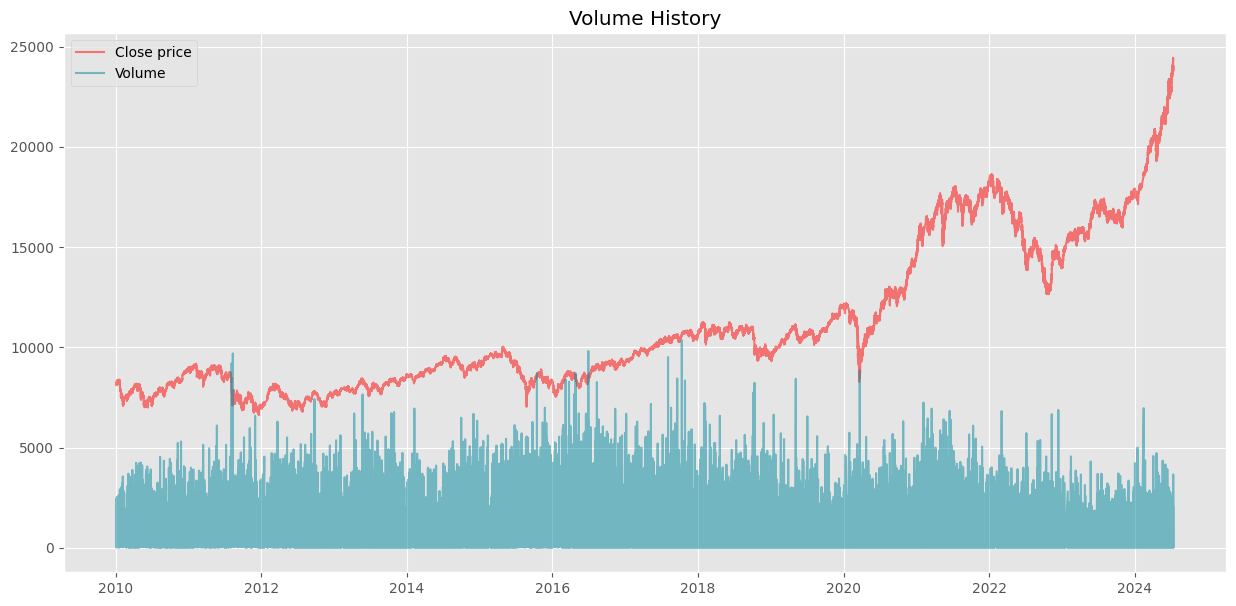

In [141]:
plt.figure(figsize = (15,7))
plt.plot(df['close'], color = 'red', alpha = 0.5, label = 'Close price')
plt.plot(df['volume'], color = '#01889f', alpha = 0.5, label = 'Volume')
plt.legend(loc='upper left') #左上角顯示圖例
plt.title('Volume History');

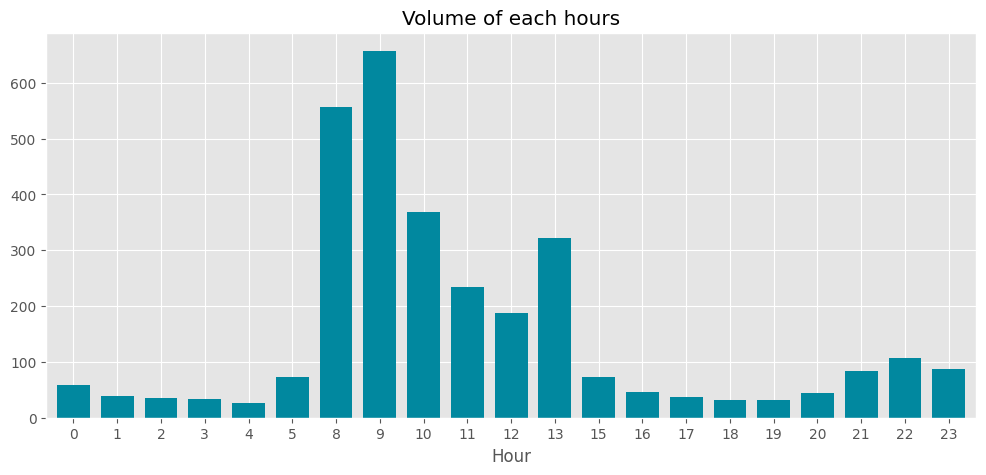

In [142]:
data = df[(df.index >= '2017-05-15 00:00:00')].copy()
#2017/5之後有夜盤所以有資料
plt.figure(figsize = (12,5))
data.groupby(['Hour'])['volume'].mean().plot(kind='bar', width=0.75, color='#01889f')
plt.xticks(rotation = 0)
plt.title('Volume of each hours');

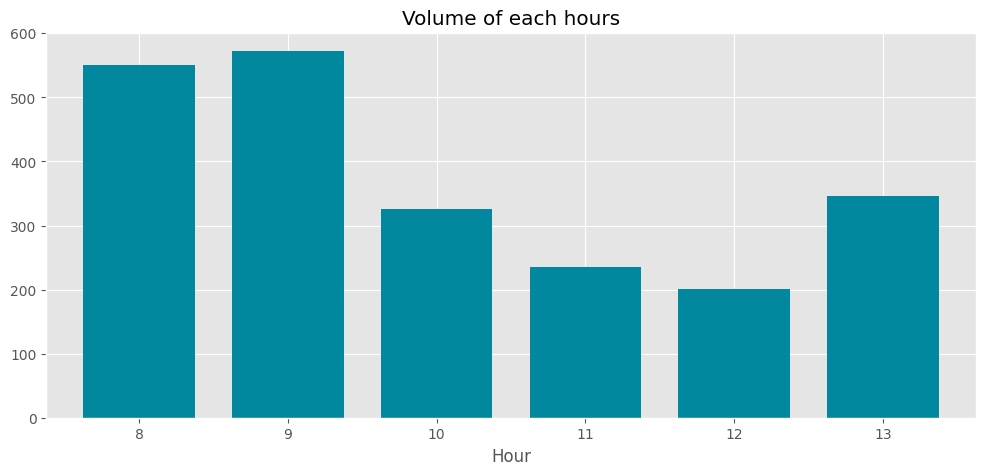

In [143]:
data = df[(df.index < '2017-05-15 00:00:00')].copy()
plt.figure(figsize = (12,5))
data.groupby(['Hour'])['volume'].mean().plot(kind='bar', width=0.75, color='#01889f')
plt.xticks(rotation = 0)
plt.title('Volume of each hours');

### reample
* 注意
    * 台指期的 9:01 是指 9:00 ~ 9:01
    * 因此 9:03 的 3分K 應為 9:01 ~ 9:03
    * label='left' 顯示方式轉為整點開始
    * **日K 需要特別處理**
        * 時間直接減 8hr，再做 resample 即可
        * 時間要往後加一天，才不會用到未來資料
            * 8/8 日K 會用到 8/9 的 5:00
            * 計算 8/8 當天報酬率，是從 8/8 8:45 ~ 8/9 5:00
            * 使用外部資料需特別小心，因此通常會加一天處理
        * 2017-5 之後才有夜盤 (日K 多了 14 小時)
            * 日K 資料若包含日夜盤，通常會回測 2017-5 之後的資料，不然K棒的資訊含量不同
            * 使用 2017-5 之前的資料，時間更長，但回測上可能需注意市場結構轉變
            * 或者直接不考慮夜盤計算日K，就不會遇到這些問題了

In [144]:
rule = '3T'
Morning = df[(df['Hour'] >= 8) & (df['Hour'] <= 13)]
Morning.index = Morning.index + dt.timedelta(minutes=15)
#我们把选出的数据的时间索引每条记录都往后推15分钟。
Morning.iloc[0:10]
#也可以9:-1資料由後往前

,open,high,low,close,volume,Hour
datetime,,,,,,
2010-01-04 09:01:00,8203.0,8208.0,8184.0,8187.0,1108,8
2010-01-04 09:02:00,8187.0,8195.0,8186.0,8193.0,429,8
2010-01-04 09:03:00,8194.0,8201.0,8193.0,8200.0,419,8
2010-01-04 09:04:00,8200.0,8203.0,8198.0,8200.0,295,8
2010-01-04 09:05:00,8200.0,8201.0,8195.0,8197.0,187,8
2010-01-04 09:06:00,8198.0,8200.0,8195.0,8197.0,219,8
2010-01-04 09:07:00,8197.0,8200.0,8195.0,8196.0,207,8
2010-01-04 09:08:00,8196.0,8199.0,8195.0,8197.0,167,8
2010-01-04 09:09:00,8197.0,8198.0,8196.0,8196.0,124,8


In [145]:
# 確認 9:03 及 9:06 的 open 是 9:01 及 9:04 的 open。#右閉左開
Morning.resample(rule=rule, closed='right', label='right').last()[['close']].iloc[0:3]

,close
datetime,
2010-01-04 09:03:00,8200.0
2010-01-04 09:06:00,8197.0
2010-01-04 09:09:00,8196.0


In [146]:
# label='left' => 時間轉為左側時間 #左閉右開
Morning.resample(rule=rule, closed='left', label='left').last()[['close']].iloc[0:3]

,close
datetime,
2010-01-04 09:00:00,8193.0
2010-01-04 09:03:00,8197.0
2010-01-04 09:06:00,8197.0


In [147]:
rule = '60T'

Morning = df[(df['Hour'] >= 8) & (df['Hour'] <= 13)]
Morning.index = Morning.index + dt.timedelta(minutes=15)
#選擇日盤交易時段 8:46~13:45
d1 = Morning.resample(rule=rule, closed='right', label='left').first()[['open']]
d2 = Morning.resample(rule=rule, closed='right', label='left').max()[['high']]
d3 = Morning.resample(rule=rule, closed='right', label='left').min()[['low']]
d4 = Morning.resample(rule=rule, closed='right', label='left').last()[['close']]
d5 = Morning.resample(rule=rule, closed='right', label='left').sum()[['volume']]

df_Morning = pd.concat([d1,d2,d3,d4,d5], axis=1)
df_Morning = df_Morning.dropna()
df_Morning.index = df_Morning.index - dt.timedelta(minutes=15)
df_Morning.head()

,open,high,low,close,volume
datetime,,,,,
2010-01-04 08:45:00,8203.0,8211.0,8181.0,8187.0,17247
2010-01-04 09:45:00,8187.0,8188.0,8101.0,8165.0,31531
2010-01-04 10:45:00,8167.0,8180.0,8158.0,8172.0,8859
2010-01-04 11:45:00,8172.0,8207.0,8167.0,8197.0,12329
2010-01-04 12:45:00,8198.0,8200.0,8165.0,8166.0,13915


In [148]:
rule = '60T'

Night = df[(df['Hour'] < 8) | (df['Hour'] > 13)]

d1 = Night.resample(rule=rule, closed='right', label='left').first()[['open']]
d2 = Night.resample(rule=rule, closed='right', label='left').max()[['high']]
d3 = Night.resample(rule=rule, closed='right', label='left').min()[['low']]
d4 = Night.resample(rule=rule, closed='right', label='left').last()[['close']]
d5 = Night.resample(rule=rule, closed='right', label='left').sum()[['volume']]

df_Night = pd.concat([d1,d2,d3,d4,d5], axis=1)
df_Night = df_Night.dropna()
df_Night.head()

,open,high,low,close,volume
datetime,,,,,
2017-05-15 15:00:00,10023.0,10034.0,10020.0,10033.0,925
2017-05-15 16:00:00,10032.0,10032.0,10028.0,10030.0,300
2017-05-15 17:00:00,10030.0,10030.0,10026.0,10027.0,137
2017-05-15 18:00:00,10026.0,10028.0,10025.0,10027.0,148
2017-05-15 19:00:00,10028.0,10030.0,10028.0,10030.0,40


In [149]:
df_Day = pd.concat([df_Morning, df_Night], axis=0)
df_Day = df_Day.sort_index(ascending=True)
#将合并后的数据按时间索引进行升序排序，以确保数据按时间顺序排列。
df_Day.head()

,open,high,low,close,volume
datetime,,,,,
2010-01-04 08:45:00,8203.0,8211.0,8181.0,8187.0,17247
2010-01-04 09:45:00,8187.0,8188.0,8101.0,8165.0,31531
2010-01-04 10:45:00,8167.0,8180.0,8158.0,8172.0,8859
2010-01-04 11:45:00,8172.0,8207.0,8167.0,8197.0,12329
2010-01-04 12:45:00,8198.0,8200.0,8165.0,8166.0,13915


In [150]:
# ### 特例：日K處理 ###
# day = df.loc['2017-5-15':].copy()
# df_day.index = df_day.index - dt.timedelta(hours=8)

# d1 = df_day.resample(rule='1D', closed='right', label='left').first()[['open']]
# d2 = df_day.resample(rule='1D', closed='right', label='left').max()[['high']]
# d3 = df_day.resample(rule='1D', closed='right', label='left').min()[['low']]
# d4 = df_day.resample(rule='1D', closed='right', label='left').last()[['close']]
# d5 = df_day.resample(rule='1D', closed='right', label='left').sum()[['volume']]

# df_day = pd.concat([d1,d2,d3,d4,d5], axis=1)
# df_day = df_day.dropna()
# df_day.index = df_day.index + dt.timedelta(days=1) ##回測時結算日也要加一天
# df_day.tail()

### 選擇回測資料

In [151]:
# df_Morning['Month'] = df_Morning.index.map(lambda x: x.month)
# df_Morning['Weekday'] = df_Morning.index.map(lambda x: x.weekday)+1
df_Morning['Hour'] = df_Morning.index.hour
#在df_Morning数据框中新增一列Hour，该列包含每个时间索引对应的小时数。

In [152]:
trainData = df_Morning[(df_Morning.index >= '2010-01-01 00:00:00') & (df_Morning.index <= '2022-06-30 00:00:00')].copy() #樣本內
testData = df_Morning[(df_Morning.index >= '2022-07-01 00:00:00') & (df_Morning.index <= '2024-06-30 00:00:00')].copy()  #樣本外

In [153]:
trainData.head(3)

,open,high,low,close,volume,Hour
datetime,,,,,,
2010-01-04 08:45:00,8203.0,8211.0,8181.0,8187.0,17247,8
2010-01-04 09:45:00,8187.0,8188.0,8101.0,8165.0,31531,9
2010-01-04 10:45:00,8167.0,8180.0,8158.0,8172.0,8859,10


In [154]:
testData.tail(3)

,open,high,low,close,volume,Hour
datetime,,,,,,
2024-06-28 10:45:00,23082.0,23086.0,22960.0,23037.0,15946,10
2024-06-28 11:45:00,23038.0,23064.0,23011.0,23038.0,7580,11
2024-06-28 12:45:00,23039.0,23042.0,22954.0,22983.0,15303,12


### 取得結算日資料
* https://www.taifex.com.tw/cht/5/futIndxFSP

In [155]:
from google.colab import drive
import pandas as pd

# 挂载 Google Drive
drive.mount('/content/drive')

# 检查文件是否存在
!ls /content/drive/My\ Drive/

# 加载数据
file_path = '/content/drive/My Drive/settlementDate.csv'
settlementDate_ = pd.read_csv(file_path)
settlementDate_.columns = ['settlementDate', 'futures', 'settlementPrice']
settlementDate_


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 02應徵附表.pdf
'0804 大社課'
 101-110交大科管所試題.pdf
 101-110交大管科所試題.pdf
 102-110交大資訊財金所試題.pdf
 103-110成大企研所.pdf
 103-112中興行銷所試題.pdf
 104-112北大金融所.pdf
 104-112台師大管研所+全球策略所.pdf
 105-110台大商研所+106-112台大經濟系大轉.pdf
 105-111台大國企所.pdf
 105-111台大農經所.pdf
 106-111中央財金所.pdf
 106-112中興企研所試題.pdf
'106-112中興財金所 (1).pdf'
 106-112中興財金所.pdf
 106-112政大財政所.pdf
 106-112清大科管所試題.pdf
 107-112成大財金所.pdf
'109年台大英文B卷題目與解答 (1).pdf'
 109年台大英文B卷題目與解答.pdf
 110年台大英文B卷題目與解答.pdf
'111年台大英文A卷題目與解答 (1).pdf'
 111年台大英文A卷題目與解答.pdf
 111年台大英文B卷題目與解答.pdf
'111 清大科管所英文題目+解答.pdf'
'112碩士班一般入學甲組 2.odt'
 112碩士班一般入學甲組.odt
 113學年度碩考_初試合格錄取名單.pdf.download
 113年商學院常考問答題複習.pdf
 113放棄聲明書.docx
 113放棄聲明書.gdoc
 113碩考_第1梯次備取遞補名單.pdf
 113碩考_第2梯次備取遞補名單.pdf
 113碩考-複試錄取名單.pdf
 2023年個經第3次線上小考解答-政府介入市場.pdf
 2023年總經第3次線上小考答案-貨幣理論.pdf
'20240611_Global Investment Research.pdf'
 2af11a98-e7b0-46ad-ad6b-4b82d3845c1f.pdf
'3398961-E20240223 

,settlementDate,futures,settlementPrice
0,2024/07/26,202407W4,22069
1,2024/07/17,202407,23680
2,2024/07/10,202407W2,23996
3,2024/07/03,202407W1,23138
4,2024/06/26,202406W4,22965
...,...,...,...
740,1999/01/21,199901,6332
741,1998/12/17,199812,6695
742,1998/11/19,199811,7185
743,1998/10/22,199810,7068


In [156]:
file_path ='/content/drive/My Drive/settlementDate.csv'
settlementDate_ = pd.read_csv(file_path)
settlementDate_.columns = ['settlementDate', 'futures', 'settlementPrice']
settlementDate_

,settlementDate,futures,settlementPrice
0,2024/07/26,202407W4,22069
1,2024/07/17,202407,23680
2,2024/07/10,202407W2,23996
3,2024/07/03,202407W1,23138
4,2024/06/26,202406W4,22965
...,...,...,...
740,1999/01/21,199901,6332
741,1998/12/17,199812,6695
742,1998/11/19,199811,7185
743,1998/10/22,199810,7068


以下

In [157]:
bool_ = [False if 'W' in i else True for i in settlementDate_['futures']]

In [158]:
len(list(settlementDate_[bool_]['futures']))

311

In [159]:
12*25 + 4 + 7 # 1999~2023 共 25 年＊12個月，再加上 1998 年的9,10,11,12月期貨和今年的 1,2,3,4,5,6,7月期貨

311

In [160]:
settlementDate = [i.replace('/','-') for i in list(settlementDate_[bool_]['settlementDate'])]
#将每个日期字符串中的斜杠 / 替换为短横线 -，这样可以使日期格式更标准化。

In [161]:
settlementDate = [pd.to_datetime(i).date() for i in settlementDate]

In [162]:
settlementDate[-5:] #获取settlementDate列表的最后五个元素

[datetime.date(1999, 1, 21),
 datetime.date(1998, 12, 17),
 datetime.date(1998, 11, 19),
 datetime.date(1998, 10, 22),
 datetime.date(1998, 9, 17)]

## 回測假設
* 換月轉倉：結算日當天直接平倉
* 進場限制：結算日當天不進場
* 報酬計算：200 * 點數
* 手續費+滑價：單邊 600元

In [163]:
#滑價
#舉例來說：
#以做多台指期貨為例，股價突然上漲，而你想追價買進，
#本來想買在9500點，但這時間想買的人很多，於是你買到9502點，而這多付2點的代價，就是滑價。

In [164]:
!pip install pandas_ta
import pandas_ta as ta

#參數設定
fund = 1000000
feePaid = 600
length = 15
NumStd = 1.5
K = 0.05

#指標計算
# trainData['H'] = trainData['high'].shift(1).rolling(window=length, center=False).max()
# trainData['L'] = trainData['low'].shift(1).rolling(window=length, center=False).min()
#trainData['MA'] = trainData['close'].rolling(window=length, center=False).mean()
#trainData['STD'] = trainData['close'].rolling(window=length, center=False).std()
#trainData['upLine'] = trainData['MA'] + NumStd*trainData['STD']
#trainData['downLine'] = trainData['MA'] - NumStd*trainData['STD']
trainData['ADX'] = ta.adx(trainData['high'], trainData['low'], trainData['close'])['ADX_14']
trainData['+DI'] = ta.adx(trainData['high'], trainData['low'], trainData['close'])['DMP_14']
trainData['-DI'] = ta.adx(trainData['high'], trainData['low'], trainData['close'])['DMN_14']

trainData.tail(3)

,open,high,low,close,volume,Hour,ADX,+DI,-DI
datetime,,,,,,,,,
2022-06-29 10:45:00,15083.0,15091.0,14994.0,15034.0,16523,10,27.145601,18.086943,36.271131
2022-06-29 11:45:00,15036.0,15066.0,15015.0,15051.0,11264,11,27.596101,17.437506,34.968765
2022-06-29 12:45:00,15051.0,15058.0,15007.0,15019.0,17675,12,28.068810,16.788328,34.250900


In [165]:
!pip install ta
import ta

In [166]:
print(df.columns)

Index(['open', 'high', 'low', 'close', 'volume', 'Hour'], dtype='object')


In [167]:
df['ADX'] = ta.trend.ADXIndicator(high=df['open'], low=df['close'], close=df['low'], window=252).adx()
df['+DI'] = ta.trend.ADXIndicator(high=df['open'], low=df['close'], close=df['low'], window=252).adx_pos()
df['-DI'] = ta.trend.ADXIndicator(high=df['open'], low=df['close'], close=df['low'], window=252).adx_neg()

In [168]:
df['Buy_Signal'] = (df['+DI'] > df['-DI']) & (df['+DI'].shift(1) <= df['-DI'].shift(1)) & (df['ADX'] > 25)
df['Sell_Signal'] = (df['-DI'] > df['+DI']) & (df['-DI'].shift(1) <= df['+DI'].shift(1)) & (df['ADX'] > 25)

In [169]:
print(df[['Buy_Signal', 'Sell_Signal']])

                     Buy_Signal  Sell_Signal
datetime                                    
2010-01-04 08:46:00       False        False
2010-01-04 08:47:00       False        False
2010-01-04 08:48:00       False        False
2010-01-04 08:49:00       False        False
2010-01-04 08:50:00       False        False
...                         ...          ...
2024-07-12 15:53:00       False        False
2024-07-12 15:54:00       False        False
2024-07-12 15:55:00       False        False
2024-07-12 15:56:00       False        False
2024-07-12 15:57:00       False        False

[2486698 rows x 2 columns]


In [170]:
df.to_csv('台指期貨交易信號.csv', index=False)

In [171]:
print(df.columns)

Index(['open', 'high', 'low', 'close', 'volume', 'Hour', 'ADX', '+DI', '-DI',
       'Buy_Signal', 'Sell_Signal'],
      dtype='object')


In [172]:
buy_signals = df[df['Buy_Signal']]
sell_signals = df[df['Sell_Signal']]

print("Buy Signals:\n", buy_signals[['close', 'ADX', '+DI', '-DI']])
print("Sell Signals:\n", sell_signals[['close', 'ADX', '+DI', '-DI']])

Buy Signals:
 Empty DataFrame
Columns: [close, ADX, +DI, -DI]
Index: []
Sell Signals:
 Empty DataFrame
Columns: [close, ADX, +DI, -DI]
Index: []


In [173]:
# Now create df_arr with the calculated indicators
df_arr = trainData[['open', 'high', 'low', 'close', 'ADX', '+DI', '-DI']].values
time_arr = np.array(trainData.index)
date_arr = [pd.to_datetime(i).date() for i in time_arr]

#翻譯蒟蒻
# date_arr = []
# for i in time_arr:
#     date_arr.append(pd.to_datetime(i).date())

In [174]:
print(trainData.columns)

Index(['open', 'high', 'low', 'close', 'volume', 'Hour', 'ADX', '+DI', '-DI'], dtype='object')


In [175]:
date_arr

[datetime.date(2010, 1, 4),
 datetime.date(2010, 1, 4),
 datetime.date(2010, 1, 4),
 datetime.date(2010, 1, 4),
 datetime.date(2010, 1, 4),
 datetime.date(2010, 1, 5),
 datetime.date(2010, 1, 5),
 datetime.date(2010, 1, 5),
 datetime.date(2010, 1, 5),
 datetime.date(2010, 1, 5),
 datetime.date(2010, 1, 6),
 datetime.date(2010, 1, 6),
 datetime.date(2010, 1, 6),
 datetime.date(2010, 1, 6),
 datetime.date(2010, 1, 6),
 datetime.date(2010, 1, 7),
 datetime.date(2010, 1, 7),
 datetime.date(2010, 1, 7),
 datetime.date(2010, 1, 7),
 datetime.date(2010, 1, 7),
 datetime.date(2010, 1, 8),
 datetime.date(2010, 1, 8),
 datetime.date(2010, 1, 8),
 datetime.date(2010, 1, 8),
 datetime.date(2010, 1, 8),
 datetime.date(2010, 1, 11),
 datetime.date(2010, 1, 11),
 datetime.date(2010, 1, 11),
 datetime.date(2010, 1, 11),
 datetime.date(2010, 1, 11),
 datetime.date(2010, 1, 12),
 datetime.date(2010, 1, 12),
 datetime.date(2010, 1, 12),
 datetime.date(2010, 1, 12),
 datetime.date(2010, 1, 12),
 datetime.

In [176]:
import pandas as pd

# 假设 df 是你的 DataFrame
df = pd.read_csv('/content/drive/MyDrive/TXF_1m .csv')

# 打印列名及其索引
for i, col in enumerate(df.columns):
    print(f'列索引 {i}: {col}')


列索引 0: Unnamed: 0
列索引 1: datetime
列索引 2: Open
列索引 3: High
列索引 4: Low
列索引 5: Close
列索引 6: Volume
列索引 7: Date
列索引 8: Time


In [177]:
# Handle NaN values (choose one method)
trainData.dropna(subset=['ADX', '+DI', '-DI'], inplace=True)  # Drop rows with NaN
# OR
# trainData[['ADX', '+DI', '-DI']] = trainData[['ADX', '+DI', '-DI']].fillna(0)  # Fill NaN with 0

# Recreate df_arr and time_arr AFTER handling NaNs
df_arr = trainData[['open', 'high', 'low', 'close', 'ADX', '+DI', '-DI']].values
time_arr = np.array(trainData.index)

print(df_arr[:5])  # Now this should show the correct values

[[8334.         8353.         8327.         8343.           16.56418607
    26.38996886   18.18657349]
 [8342.         8352.         8320.         8333.           16.41803954
    24.9712362    18.38486441]
 [8332.         8337.         8306.         8321.           15.63791222
    23.64506787   19.80690246]
 [8318.         8337.         8281.         8292.           14.23913542
    21.43090235   22.1325847 ]
 [8292.         8309.         8262.         8285.           13.70930492
    19.75858082   23.56004161]]


### 做多

In [178]:
import pandas as pd

# 读取 CSV 文件
file_path = '/content/drive/MyDrive/TXF_1m .csv'
data = pd.read_csv(file_path)

# 打印列名以检查正确的列名
print(data.columns)

Index(['Unnamed: 0', 'datetime', 'Open', 'High', 'Low', 'Close', 'Volume',
       'Date', 'Time'],
      dtype='object')


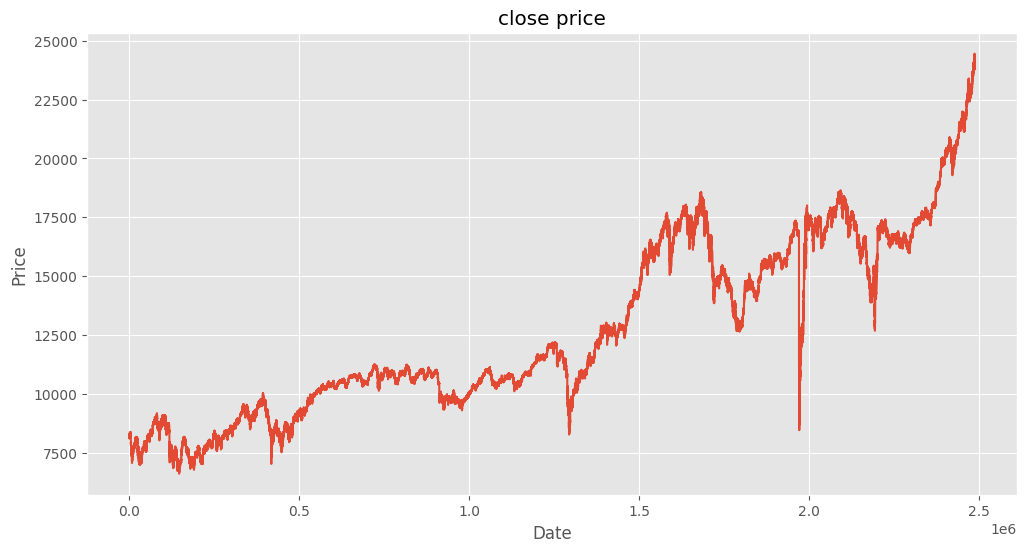

In [179]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df.index, df['Close'])
plt.title('close price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()
plt.close()
#将原始的 trainData 转换为 NumPy 数组以加快计算速度

In [180]:
 print(trainData.columns)

Index(['open', 'high', 'low', 'close', 'volume', 'Hour', 'ADX', '+DI', '-DI'], dtype='object')


In [181]:
print(trainData['volume'])

datetime
2010-01-11 10:45:00    13386
2010-01-11 11:45:00    13040
2010-01-11 12:45:00    16390
2010-01-12 08:45:00    21760
2010-01-12 09:45:00    24552
                       ...  
2022-06-29 08:45:00    37462
2022-06-29 09:45:00    17715
2022-06-29 10:45:00    16523
2022-06-29 11:45:00    11264
2022-06-29 12:45:00    17675
Name: volume, Length: 15316, dtype: int64


In [182]:
print(df_arr.shape)
print(df_arr[:5])

(15316, 7)
[[8334.         8353.         8327.         8343.           16.56418607
    26.38996886   18.18657349]
 [8342.         8352.         8320.         8333.           16.41803954
    24.9712362    18.38486441]
 [8332.         8337.         8306.         8321.           15.63791222
    23.64506787   19.80690246]
 [8318.         8337.         8281.         8292.           14.23913542
    21.43090235   22.1325847 ]
 [8292.         8309.         8262.         8285.           13.70930492
    19.75858082   23.56004161]]


Buy Price: 7316.0, time: 2010-02-09T12:45:00.000000000
Sell Price: 7770.0, time: 2010-03-22T09:45:00.000000000
Trade completed

Buy Price: 7270.0, time: 2010-05-28T09:45:00.000000000
Sell Price: 7360.0, time: 2010-06-18T09:45:00.000000000
Trade completed

Buy Price: 7463.0, time: 2010-06-21T09:45:00.000000000
Sell Price: 7450.0, time: 2010-06-23T09:45:00.000000000
Trade completed

Buy Price: 7324.0, time: 2010-07-05T12:45:00.000000000
Sell Price: 7905.0, time: 2010-08-11T09:45:00.000000000
Trade completed

Buy Price: 7911.0, time: 2010-08-13T12:45:00.000000000
Sell Price: 7886.0, time: 2010-08-16T09:45:00.000000000
Trade completed

Buy Price: 7943.0, time: 2010-08-16T11:45:00.000000000
Sell Price: 7716.0, time: 2010-08-30T12:45:00.000000000
Trade completed

Buy Price: 7701.0, time: 2010-09-02T09:45:00.000000000
Sell Price: 7848.0, time: 2010-09-08T12:45:00.000000000
Trade completed

Buy Price: 7865.0, time: 2010-09-09T08:45:00.000000000
Sell Price: 8217.0, time: 2010-09-23T10:45:00.000

<Axes: xlabel='datetime'>

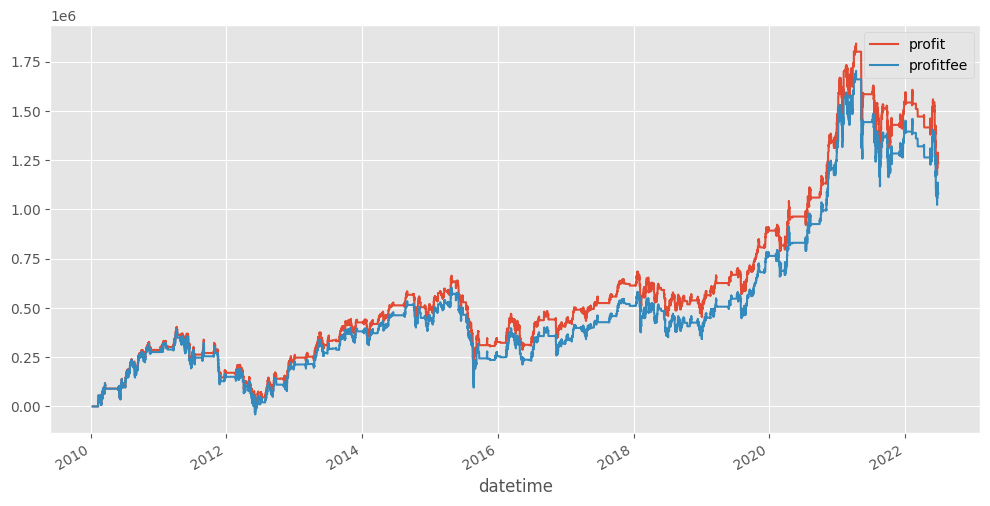

In [183]:
#建立存放資料的單位
BS = None
buy = []
sell = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []

# 定義列的索引
OPEN, HIGH, LOW, CLOSE, ADX, PLUS_DI, MINUS_DI = range(7)

#開始交易流程
for i in range(1, len(df_arr)):  # 從1開始，因為我們需要比較前一天的數據
    #回測期間最後一天就跳出這個迴圈
    if i == len(df_arr)-1:
        break

    ## 進場邏輯
    ### 當正DI由下往上穿過負DI，同时ADX高于25時進場做多
    entryLong = (df_arr[i, PLUS_DI] > df_arr[i, MINUS_DI] and
                 df_arr[i-1, PLUS_DI] <= df_arr[i-1, MINUS_DI] and
                 df_arr[i, ADX] > 25)

    ## 出場邏輯
    ### 當-DI由下往上穿過+DI，同时ADX高于25時出場
    exitLong = (df_arr[i, MINUS_DI] > df_arr[i, PLUS_DI] and
                df_arr[i-1, MINUS_DI] <= df_arr[i-1, PLUS_DI] and
                df_arr[i, ADX] > 25)

    #還沒進場不用計算損益
    if BS == None:
        profit_list.append(0)
        profit_fee_list.append(0)

    #確認進場&相關設定
    if BS == None and entryLong:
        #更改狀態至做多
        BS = 'B'
        #紀錄進場時間
        t = i+1
        buy.append(t)
        print(f"Buy Price: {df_arr[t,CLOSE]}, time: {time_arr[t]}")

    #進場開始計算未實現損益
    elif BS == 'B':
        profit = 200 * (df_arr[i+1,CLOSE] - df_arr[i,CLOSE])
        profit_list.append(profit)

        #近場條件達成，計算未實現損益-交易成本
        if exitLong or i == len(df_arr)-2:
            pl_round = 200 * (df_arr[i+1,CLOSE] - df_arr[t,CLOSE])
            profit_fee = profit - feePaid*2
            profit_fee_list.append(profit_fee)
            #紀錄出場時間
            sell.append(i+1)
            #重置交易狀態
            BS = None
            print(f"Sell Price: {df_arr[i+1,CLOSE]}, time: {time_arr[i+1]}")
            print("Trade completed")
            print()
            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2
            profit_fee_list_realized.append(profit_fee_realized)
        #出場條件未達成，計算未實現損益
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)

equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=trainData.index[:len(profit_list)])
equity.plot(grid=True, figsize=(12,6))

In [184]:
print(equity)

                        profit  profitfee
datetime                                 
2010-01-11 10:45:00        0.0        0.0
2010-01-11 11:45:00        0.0        0.0
2010-01-11 12:45:00        0.0        0.0
2010-01-12 08:45:00        0.0        0.0
2010-01-12 09:45:00        0.0        0.0
...                        ...        ...
2022-06-28 12:45:00  1235800.0  1082200.0
2022-06-29 08:45:00  1235800.0  1082200.0
2022-06-29 09:45:00  1235800.0  1082200.0
2022-06-29 10:45:00  1235800.0  1082200.0
2022-06-29 11:45:00  1235800.0  1082200.0

[15315 rows x 2 columns]


### 做空

串流輸出內容已截斷至最後 5000 行。
sell short at 2020-05-13T10:45:00.000000000
buytocover at 2020-05-13T11:45:00.000000000
trade completed

sell short at 2020-05-13T12:45:00.000000000
buytocover at 2020-05-14T08:45:00.000000000
trade completed

sell short at 2020-05-14T09:45:00.000000000
buytocover at 2020-05-14T10:45:00.000000000
trade completed

sell short at 2020-05-14T11:45:00.000000000
buytocover at 2020-05-14T12:45:00.000000000
trade completed

sell short at 2020-05-15T08:45:00.000000000
buytocover at 2020-05-15T09:45:00.000000000
trade completed

sell short at 2020-05-15T10:45:00.000000000
buytocover at 2020-05-15T11:45:00.000000000
trade completed

sell short at 2020-05-15T12:45:00.000000000
buytocover at 2020-05-18T08:45:00.000000000
trade completed

sell short at 2020-05-18T09:45:00.000000000
buytocover at 2020-05-18T10:45:00.000000000
trade completed

sell short at 2020-05-18T11:45:00.000000000
buytocover at 2020-05-18T12:45:00.000000000
trade completed

sell short at 2020-05-19T08:45:00.

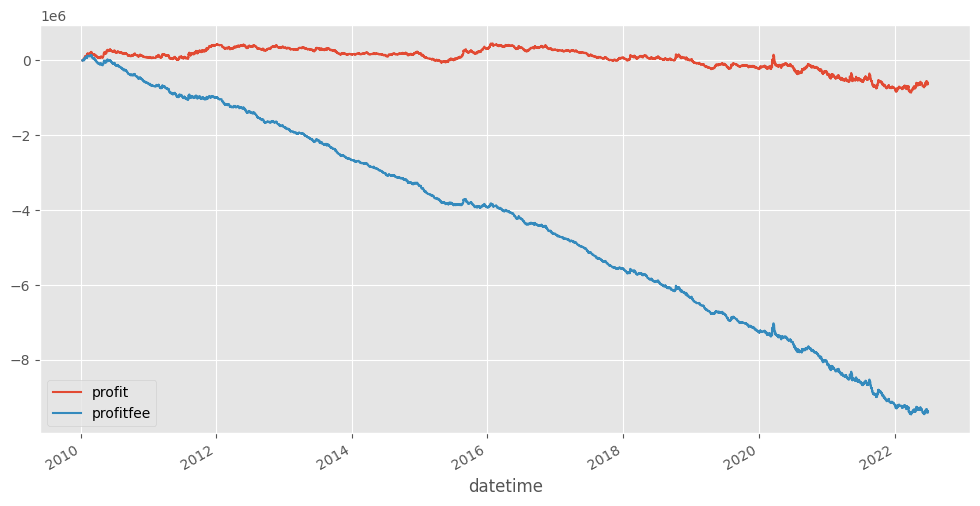

In [185]:
BS = None
sellshort = []
buytocover = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []

for i in range(len(df_arr)):

    if i == len(df_arr)-1:
        break

    ## 進場邏輯
    entrySellShort = "Put your answer in the blank!"
    entryCondition = date_arr[i] not in settlementDate

    ## 出場邏輯
    exitBuyToCover = "Put your answer in the blank!"
    exitCondition = date_arr[i] in settlementDate and df_arr[i,5] >= 11

    if BS == 'S':
        stopLoss = df_arr[i,3] >= df_arr[t,0] * (1+K)
        stopProfit = df_arr[i,3] <= df_arr[t,0] * (1-K)

#     if exitCondition == True:
#         print(f'{time_arr[i]}')

    if BS == None:
        profit_list.append(0)
        profit_fee_list.append(0)

        if entrySellShort and entryCondition:
            BS = 'S'
            t = i+1
            sellshort.append(t)
            print("sell short at {}".format(time_arr[t]))


    elif BS == 'S':
        profit = 200 * (df_arr[i,0] - df_arr[i+1,0])
        profit_list.append(profit)

        if exitBuyToCover or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (df_arr[t,0] - df_arr[i+1,0])
            profit_fee = profit - feePaid*2
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)
            BS = None
            print("buytocover at {}".format(time_arr[i+1]))
            print("trade completed")
            print()

            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2
            profit_fee_list_realized.append(profit_fee_realized)

        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)


equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=trainData.index)
# print(equity)
equity.plot(grid=True, figsize=(12,6));

### 多空都做(回家看)

In [186]:
BS = None
buy = []
sell = []
sellshort = []
buytocover = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []
rets = []

for i in range(len(df_arr)):

    if i == len(df_arr)-1:
        break

    ## 進場邏輯
    entryLong = df_arr[i,3] > df_arr[i,8]
    entrySellShort = df_arr[i,3] < df_arr[i,9]
    entryCondition = date_arr[i] not in settlementDate

    ## 出場邏輯
    exitShort = df_arr[i,3] <= df_arr[i,9]
    exitBuyToCover = df_arr[i,3] >= df_arr[i,8]
    exitCondition = date_arr[i] in settlementDate and df_arr[i,5] >= 11

    ## 停利停損邏輯
    if BS == 'B':
        stopLoss = df_arr[i,3] <= df_arr[t,0] * (1-K)
        stopProfit = df_arr[i,3] >= df_arr[t,0] * (1+K)
    elif BS == 'S':
        stopLoss = df_arr[i,3] >= df_arr[t,0] * (1+K)
        stopProfit = df_arr[i,3] <= df_arr[t,0] * (1-K)

#     if exitCondition == True:
#         print(f'{time_arr[i]}')

    if BS == None:
        profit_list.append(0)
        profit_fee_list.append(0)

        if entryLong and entryCondition:
            BS = 'B'
            t = i+1
            buy.append(t)
            print("Enter Long Position")
            print("Buy Price: {}, time: {}".format(df_arr[t,0], time_arr[t]))

        elif entrySellShort and entryCondition:
            BS = 'S'
            t = i+1
            sellshort.append(t)
            print("Enter Short Position")
            print("Sell Price: {}, time: {}".format(df_arr[t,0], time_arr[t]))

    elif BS == 'B':
        profit = 200 * (df_arr[i+1,0] - df_arr[i,0])
        profit_list.append(profit)

        if exitShort or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (df_arr[i+1,0] - df_arr[t,0])
            profit_fee = profit - feePaid*2
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            BS=None
            print("Sell Price: {}, time: {}".format(df_arr[i+1,0], time_arr[i+1]))
            print("Trade completed")
            print()

            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2
            profit_fee_list_realized.append(profit_fee_realized)
            rets.append(profit_fee_realized/(200*df_arr[t,0]))

        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)

    elif BS == 'S':
        profit = 200 * (df_arr[i,0] - df_arr[i+1,0])
        profit_list.append(profit)

        if exitBuyToCover or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (df_arr[t,0] - df_arr[i+1,0])
            profit_fee = profit - feePaid*2
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)
            BS = None
            print("Buycover Price: {}, time: {}".format(df_arr[i+1,0], time_arr[i+1]))
            print("Trade completed")
            print()

            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2
            profit_fee_list_realized.append(profit_fee_realized)
            rets.append(profit_fee_realized/(200*df_arr[t,0]))

        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)


equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=trainData.index)
# print(equity)
equity.plot(grid=True, figsize=(12,6));

IndexError: index 8 is out of bounds for axis 1 with size 7

In [ ]:
print(equity)

### 做多加碼

In [ ]:
BS = None
Position = 0
buy_price = 0
add_price = 0
buy = []
sell = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []
cost_list = []
rets = []

for i in range(len(df_arr)):

    #回測期間最後一天就跳出這個迴圈
    if i == len(df_arr)-1:
        break

    ## 進場邏輯
    #當收盤價突破布林上軌
    entryLong = df_arr[i,3] > df_arr[i,8]
    #結算日不進場
    entryCondition = date_arr[i] not in settlementDate

    ## 出場邏輯
    ### 當收盤價跌破布林下軌
    exitShort = df_arr[i,3] <= df_arr[i,9]
    ### 結算日時放到結算
    exitCondition = date_arr[i] in settlementDate and df_arr[i,5] >= 11


    ## 停利停損邏輯
    if BS == 'B':
        stopLoss = df_arr[i,3] <= df_arr[t,0] * (1-K)
        stopProfit = df_arr[i,3] >= df_arr[t,0] * (1+K)
        #做多狀態的加碼條件
        add_condition = df_arr[i, 0] > buy_price

#     if exitCondition == True:
#         print(f'{time_arr[i]}')

    if (BS == None) & (Position == 0):

        profit_list.append(0)
        profit_fee_list.append(0)

        if entryLong and entryCondition:
            BS = 'B'
            Position = 1
            t = i+1
            buy_price = df_arr[i+1, 0]
            #將第一次進場成本紀錄在這個list中
            cost_list.append(buy_price)
            buy.append(t)

    elif BS == 'B':

        profit = 200 * (df_arr[i+1,0] - df_arr[i,0]) * Position
        profit_list.append(profit)


        if exitShort or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            if Position > 1:
              pl_round = 200 * ((Position*df_arr[i+1,0]) - np.sum(cost_list[-2:]))
            else:
              pl_round = 200 * ((Position*df_arr[i+1,0]) - cost_list[-1])
            profit_fee = profit - feePaid*2*Position
            profit_fee_list.append(profit_fee)
            sell.append(i+1)

            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2*Position
            profit_fee_list_realized.append(profit_fee_realized)
            rets.append(profit_fee_realized/(200*df_arr[t,0]))
            #重置交易狀態
            BS = None
            #重置部位數量
            Position = 0
            #重置加碼參考價
            buy_price = 0
            #重置加碼成本
            add_price = 0


        #確認部位上限&加碼條件成立
        elif (Position <= 1) & add_condition:
            #更改部位數量
            add_price = df_arr[i+1, 0]
            #將第一次進場成本紀錄在這個list中
            cost_list.append(add_price)
            Position += 1

            profit_fee = profit
            profit_fee_list.append(profit_fee)

#             print("time: {}, Buy price: {} < Market Price: {}".format(time_arr[i], buy_price, df_arr[i, 0]))
#             print("add position at {}, {}".format(time_arr[i+1], df_arr[i+1, 0]))
#             print()

        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)


equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=trainData.index)
# print(equity)
equity.plot(grid=True, figsize=(12,6));

In [ ]:
print(equity)

### 做空加碼

In [ ]:
BS = None
Position = 0
sell_price = 0
add_price = 0
sellshort = []
buytocover = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []
cost_list = []
rets = []

for i in range(len(df_arr)):

    if i == len(df_arr)-1:
        break

    ## 進場邏輯
    entrySellShort = df_arr[i,3] < df_arr[i,9]
    entryCondition = date_arr[i] not in settlementDate

    ## 出場邏輯
    exitBuyToCover = df_arr[i,3] >= df_arr[i,8]
    exitCondition = date_arr[i] in settlementDate and df_arr[i,5] >= 11

    if BS == 'S':
        stopLoss = df_arr[i,3] >= df_arr[t,0] * (1+K)
        stopProfit = df_arr[i,3] <= df_arr[t,0] * (1-K)
        add_condition = df_arr[i, 0] < sell_price

#     if exitCondition == True:
#         print(f'{time_arr[i]}')

    if (BS == None) and (Position == 0):

        profit_list.append(0)
        profit_fee_list.append(0)

        if entrySellShort and entryCondition:
            BS = 'S'
            t = i+1
            Position = 1
            sell_price  = df_arr[i+1, 0]
            cost_list.append(sell_price)
            sellshort.append(t)

    elif BS == 'S':

        profit = 200 * (df_arr[i,0] - df_arr[i+1,0]) * Position
        profit_list.append(profit)

        if exitBuyToCover or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            """
            There is something you need to do
            """
            profit_fee = profit - (feePaid*2 * Position)
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)

            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2*Position
            profit_fee_list_realized.append(profit_fee_realized)
            rets.append(profit_fee_realized/(200*df_arr[t,0]))

            BS = None
            Position = 0
            sell_price = 0
            add_price = 0

        #確認部位上限&加碼條件成立
        elif (Position <= 1) & add_condition:
            #更改部位數量
            add_price = df_arr[i+1, 0]
            cost_list.append(add_price)
            Position += 1

            profit_fee = profit
            profit_fee_list.append(profit_fee)

        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)


equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=trainData.index)
# print(equity)
equity.plot(grid=True, figsize=(12,6));

### 都做加碼（回家看）

In [ ]:
BS = None
Position = 0
buy_price = 0
sell_price = 0
add_price = 0
buy = []
sell = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []
cost_list = []
rets = []

for i in range(len(df_arr)):

    #回測期間最後一天就跳出這個迴圈
    if i == len(df_arr)-1:
        break

    ## 進場邏輯
    ### 當收盤價突破布林上軌
    entryLong = df_arr[i,3] > df_arr[i,8]
    ### 當收盤價跌破布林下軌
    entrySellShort = df_arr[i,3] < df_arr[i,9]
    ### 結算日不進場
    entryCondition = date_arr[i] not in settlementDate

    ## 出場邏輯
    ### 當收盤價跌破布林下軌
    exitShort = df_arr[i,3] <= df_arr[i,9]
    #當收盤價突破布林上軌
    exitBuyToCover = df_arr[i,3] >= df_arr[i,8]

    ### 結算日時放到結算
    exitCondition = date_arr[i] in settlementDate and df_arr[i,5] >= 11


    ## 停利停損邏輯
    if BS == 'B':
        stopLoss = df_arr[i,3] <= df_arr[t,0] * (1-K)
        stopProfit = df_arr[i,3] >= df_arr[t,0] * (1+K)
        add_condition = df_arr[i, 0] > buy_price

    elif BS == 'S':
        stopLoss = df_arr[i,3] >= df_arr[t,0] * (1+K)
        stopProfit = df_arr[i,3] <= df_arr[t,0] * (1-K)
        add_condition = df_arr[i, 0] < sell_price


#     if exitCondition == True:
#         print(f'{time_arr[i]}')

    if (BS == None) & (Position == 0):
        profit_list.append(0)
        profit_fee_list.append(0)

        if entryLong and entryCondition:
            BS = 'B'
            Position = 1
            t = i+1
            buy_price = df_arr[i+1, 0]
            cost_list.append(buy_price)
            buy.append(t)

        elif entrySellShort and entryCondition:
            BS = 'S'
            t = i+1
            Position = 1
            sell_price  = df_arr[i+1, 0]
            cost_list.append(sell_price)
            sellshort.append(t)


    elif BS == 'B':

        profit = 200 * (df_arr[i+1,0] - df_arr[i,0]) * Position
        profit_list.append(profit)

        if exitShort or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (Position*df_arr[i+1, 0] - np.sum(cost_list))
            profit_fee = profit - feePaid*2*Position
            profit_fee_list.append(profit_fee)
            sell.append(i+1)

            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2*Position
            profit_fee_list_realized.append(profit_fee_realized)
            rets.append(profit_fee_realized/(200*df_arr[t,0]))

            BS = None
            Position = 0
            buy_price = 0
            add_price = 0
            cost_list = []

        #確認部位上限&加碼條件成立
        elif (Position <= 1) & add_condition:
            #更改部位數量
            add_price = df_arr[i+1, 0]
            cost_list.append(add_price)
            Position += 1

            profit_fee = profit
            profit_fee_list.append(profit_fee)

        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)

    elif BS == 'S':

        profit = 200 * (df_arr[i,0] - df_arr[i+1,0]) * Position
        profit_list.append(profit)

        if exitBuyToCover or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (np.sum(cost_list) - Position*df_arr[i+1, 0])
            profit_fee = profit - feePaid*2*Position
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)

            #Realized PnL
            profit_fee_realized = pl_round - feePaid*2*Position
            profit_fee_list_realized.append(profit_fee_realized)
            rets.append(profit_fee_realized/(200*df_arr[t,0]))

            BS = None
            Position = 0
            sell_price = 0
            add_price = 0
            cost_list = []

        #確認部位上限&加碼條件成立
        elif (Position <= 1) & add_condition:
            #更改部位數量
            add_price = df_arr[i+1, 0]
            cost_list.append(add_price)
            Position += 1

            profit_fee = profit
            profit_fee_list.append(profit_fee)

        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)


equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=trainData.index)
# print(equity)
equity.plot(grid=True, figsize=(12,6));

績效

**績效呈現**\
1.基本指標\
2.時間損益\
3.損益分布\
4.quantstat套件

In [ ]:
import seaborn as sns
import matplotlib.pyplot as py
plt.style.use('ggplot')

In [ ]:
print(equity)

In [ ]:
equity['equity'] = equity['profitfee'] + fund
equity['drawdown_percent'] = (equity['equity']/equity['equity'].cummax()) - 1
equity['drawdown'] = equity['equity'] - equity['equity'].cummax() #前n個元素的最大值
#print(profit_fee_list_realized)
profit = equity['profitfee'].iloc[-1]
ret = equity['equity'][-1]/equity['equity'][0] - 1
mdd = abs(equity['drawdown_percent'].min())
calmarRatio = ret / mdd
tradeTimes = len(buy)
winRate = len([i for i in profit_fee_list_realized if i > 0]) / len(profit_fee_list_realized)
profitFactor = sum([i for i in profit_fee_list_realized if i>0]) / abs(sum([i for i in profit_fee_list_realized if i<0]))

print('Profit : ',profit)
print('Return : ',ret)
print('Max DrawDown : ',mdd)
print('Caimar Ratio : ',calmarRatio)
print('Trade Times : ',tradeTimes)
print('Win Rate : ',winRate)
print('Profit Factor : ',profitFactor)

In [ ]:
# 時間損益(年)
equity.index = pd.to_datetime(equity.index) #確保索引是datetime型態
years = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022']
year_ret = []
print(equity.index.year.unique())
for i in equity.index.year.unique():
    year_ret.append(equity[equity.index.year == i]['equity'].iloc[-1]/equity[equity.index.year == i]['equity'].iloc[0] - 1)

df = pd.DataFrame({'Return':year_ret},index = years)

# heatmap函式
py.figure(figsize=(10,1))
sns.heatmap(df.transpose(), annot=True, cmap='OrRd')
py.title('Return by year')
py.show()
print('')

# 時間損益(月)
group_data = equity.groupby([equity.index.year, equity.index.month])

month_ret = []
for group, data in group_data:
    month_ret.append(data['equity'].iloc[-1]/data['equity'].iloc[0] - 1)

month_ret_padded = np.append(month_ret, [np.nan] * (13*12 - len(month_ret)))
df = pd.DataFrame(np.array(month_ret_padded).reshape((13,12)), columns=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
                    index = years)

print(df)
py.figure(figsize=(15,15))
sns.heatmap(df, annot=True, cmap='OrRd')
py.title('Return by month')
py.show()

In [ ]:
# 損益分布
rets = equity['equity'].pct_change().dropna() # Calculate returns for each trade and drop missing values
print(rets)
sns.histplot(rets, kde=True)
py.xlabel('Return per trade')
py.ylabel('Frequency')
py.title('Profit Loss Distribution')
py.show()

In [ ]:
# quantstats回測報表
!pip install quantstats
import quantstats
ret = equity['equity'].pct_change(periods=1).dropna()
print(ret)
quantstats.reports.full(ret)
#quantstats.reports.html(ret,output='stats.html',title='backtest result',download_filename='result.html')

**策略參數最佳化**

In [ ]:
optimizationList = []
fund = 1000000
feePaid = 600
length = 15
NumStd = 1.5

# 最佳化參數：length & NumStd
for length in range(10,110,10): #k棒第10到第100根
    for stdTimes in np.arange(0.5, 3, 0.5):

        stdTimes = np.round(stdTimes,1)

        print('----------')
        print(f'length: {length}')
        print(f'stdTimes: {stdTimes}')

        trainData['MA'] = trainData['close'].rolling(window=length, center=False).mean()
        trainData['STD'] = trainData['close'].rolling(window=length, center=False).std()
        trainData['upLine'] = trainData['MA'] + stdTimes*trainData['STD']
        trainData['downLine'] = trainData['MA'] - stdTimes*trainData['STD']

        #df['ma'] = df['close'].rolling(window=length, center=False).mean()
        #df['std'] = df['close'].rolling(window=length, center=False).std()

        df_arr = np.array(trainData)
        time_arr = np.array(trainData.index)
        date_arr = [pd.to_datetime(i).date() for i in time_arr]

        BS = None
        Position = 0
        buy_price = 0
        add_price = 0
        buy = []
        sell = []
        profit_list = [0]
        profit_fee_list = [0]
        profit_fee_list_realized = []
        cost_list = []
        rets = []

        for i in range(len(df_arr)):

            #回測期間最後一天就跳出這個迴圈
            if i == len(df_arr)-1:
                break

            ## 進場邏輯
            #當收盤價突破布林上軌
            entryLong = df_arr[i,3] > df_arr[i,8]
            #結算日不進場
            entryCondition = date_arr[i] not in settlementDate

            ## 出場邏輯
            ### 當收盤價跌破布林下軌
            exitShort = df_arr[i,3] <= df_arr[i,9]
            ### 結算日時放到結算
            exitCondition = date_arr[i] in settlementDate and df_arr[i,5] >= 11


            ## 停利停損邏輯
            if BS == 'B':
                stopLoss = df_arr[i,3] <= df_arr[t,0] * (1-K)
                stopProfit = df_arr[i,3] >= df_arr[t,0] * (1+K)
                #做多狀態的加碼條件
                add_condition = df_arr[i, 0] > buy_price

        #     if exitCondition == True:
        #         print(f'{time_arr[i]}')

            if (BS == None) & (Position == 0):

                profit_list.append(0)
                profit_fee_list.append(0)

                if entryLong and entryCondition:
                    BS = 'B'
                    Position = 1
                    t = i+1
                    buy_price = df_arr[i+1, 0]
                    #將第一次進場成本紀錄在這個list中
                    cost_list.append(buy_price)
                    buy.append(t)

            elif BS == 'B':

                profit = 200 * (df_arr[i+1,0] - df_arr[i,0]) * Position
                profit_list.append(profit)


                if exitShort or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
                    if Position > 1:
                        pl_round = 200 * ((Position*df_arr[i+1,0]) - np.sum(cost_list[-2:]))
                    else:
                        pl_round = 200 * ((Position*df_arr[i+1,0]) - cost_list[-1])
                    profit_fee = profit - feePaid*2*Position
                    profit_fee_list.append(profit_fee)
                    sell.append(i+1)

                    # Realized PnL
                    profit_fee_realized = pl_round - feePaid*2*Position
                    profit_fee_list_realized.append(profit_fee_realized)
                    rets.append(profit_fee_realized/(200*df_arr[t,0]))
                    #重置交易狀態
                    BS = None
                    #重置部位數量
                    Position = 0
                    #重置加碼參考價
                    buy_price = 0
                    #重置加碼成本
                    add_price = 0


                #確認部位上限&加碼條件成立
                elif (Position <= 1) & add_condition:
                    #更改部位數量
                    add_price = df_arr[i+1, 0]
                    #將第一次進場成本紀錄在這個list中
                    cost_list.append(add_price)
                    Position += 1

                    profit_fee = profit
                    profit_fee_list.append(profit_fee)

        #             print("time: {}, Buy price: {} < Market Price: {}".format(time_arr[i], buy_price, df_arr[i, 0]))
        #             print("add position at {}, {}".format(time_arr[i+1], df_arr[i+1, 0]))
        #             print()

                else:
                    profit_fee = profit
                    profit_fee_list.append(profit_fee)


        equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=trainData.index)
        equity['equity'] = equity['profitfee'] + fund
        equity['drawdown_percent'] = (equity['equity'] / equity['equity'].cummax()) - 1
        equity['drawdown'] = equity['equity'] - equity['equity'].cummax()
        ret = equity['equity'][-1]/equity['equity'][0] - 1
        mdd = abs(equity['drawdown_percent'].min())
        calmarRatio = ret / mdd

        optimizationList.append([length, stdTimes, ret, calmarRatio])

print(optimizationList)

In [ ]:
optResult = pd.DataFrame(optimizationList, columns=['length','stdTimes','ret','calmarRatio'])
optResult

In [ ]:
optResult[(optResult['stdTimes'] == 2)].sort_values('ret', ascending=False).iloc[:5]

In [ ]:
import plotly
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objects as go
pyo.init_notebook_mode()

import plotly.io as io
#io.renderers.default='browser'

In [ ]:
x = np.arange(10,110,10)
y = np.arange(0.5,3,0.5)
x1, y1 = np.meshgrid(x, y)
z = np.zeros((5,10))

for x in range(0,5):
    for y in range(0,10):
        filter1 = (optResult['length']==x1[x,y])
        filter2 = (optResult['stdTimes']==y1[x,y])
        #print(vol_quote[filter1][filter2]['Value'].values[0])
        z[x,y] = optResult[filter1][filter2]['ret'].values[0]
print(z)

fig = go.Figure(data=[go.Surface(x=x1, y=y1, z=z)])
fig.update_layout(title='Surface', autosize=False, width=500, height=500,
                          margin=dict(l=50, r=50, b=50, t=50))
#plotly.offline.plot(fig, filename='ret.html')
fig.show(renderer="colab")

In [ ]:
x = np.arange(10,110,10)
y = np.arange(0.5,3,0.5)
x1, y1 = np.meshgrid(x, y)
z = np.zeros((5,10))

for x in range(0,5):
    for y in range(0,10):
        filter1 = (optResult['length']==x1[x,y])
        filter2 = (optResult['stdTimes']==y1[x,y])
        #print(vol_quote[filter1][filter2]['Value'].values[0])
        z[x,y] = optResult[filter1][filter2]['calmarRatio'].values[0]

fig = go.Figure(data=[go.Surface(x=x1, y=y1, z=z)])
fig.update_layout(title='Surface', autosize=False, width=500, height=500,
                          margin=dict(l=50, r=50, b=50, t=50))
#plotly.offline.plot(fig, filename='calmarRation.html')
fig.show(renderer="colab")

## **樣本外**

In [187]:
print(testData.columns)

Index(['open', 'high', 'low', 'close', 'volume', 'Hour'], dtype='object')


In [188]:
!pip install pandas_ta
import pandas_ta as ta

testData['ADX'] = ta.adx(testData['high'], testData['low'], testData['close'])['ADX_14']
testData['+DI'] = ta.adx(testData['high'], testData['low'], testData['close'])['DMP_14']
testData['-DI'] = ta.adx(testData['high'], testData['low'], testData['close'])['DMN_14']

testData.tail(3)

,open,high,low,close,volume,Hour,ADX,+DI,-DI
datetime,,,,,,,,,
2024-06-28 10:45:00,23082.0,23086.0,22960.0,23037.0,15946,10,22.613540,31.863450,25.820977
2024-06-28 11:45:00,23038.0,23064.0,23011.0,23038.0,7580,11,21.746505,30.936054,25.069449
2024-06-28 12:45:00,23039.0,23042.0,22954.0,22983.0,15303,12,20.493401,29.405687,27.033519


In [189]:
# Now create df_arr with the calculated indicators
df_arr = testData[['open', 'high', 'low', 'close', 'ADX', '+DI', '-DI']].values
time_arr = np.array(trainData.index)
date_arr = [pd.to_datetime(i).date() for i in time_arr]

In [191]:
print(testData.columns)

Index(['open', 'high', 'low', 'close', 'volume', 'Hour', 'ADX', '+DI', '-DI'], dtype='object')


In [192]:
date_arr

[datetime.date(2010, 1, 11),
 datetime.date(2010, 1, 11),
 datetime.date(2010, 1, 11),
 datetime.date(2010, 1, 12),
 datetime.date(2010, 1, 12),
 datetime.date(2010, 1, 12),
 datetime.date(2010, 1, 12),
 datetime.date(2010, 1, 12),
 datetime.date(2010, 1, 13),
 datetime.date(2010, 1, 13),
 datetime.date(2010, 1, 13),
 datetime.date(2010, 1, 13),
 datetime.date(2010, 1, 13),
 datetime.date(2010, 1, 14),
 datetime.date(2010, 1, 14),
 datetime.date(2010, 1, 14),
 datetime.date(2010, 1, 14),
 datetime.date(2010, 1, 14),
 datetime.date(2010, 1, 15),
 datetime.date(2010, 1, 15),
 datetime.date(2010, 1, 15),
 datetime.date(2010, 1, 15),
 datetime.date(2010, 1, 15),
 datetime.date(2010, 1, 18),
 datetime.date(2010, 1, 18),
 datetime.date(2010, 1, 18),
 datetime.date(2010, 1, 18),
 datetime.date(2010, 1, 18),
 datetime.date(2010, 1, 19),
 datetime.date(2010, 1, 19),
 datetime.date(2010, 1, 19),
 datetime.date(2010, 1, 19),
 datetime.date(2010, 1, 19),
 datetime.date(2010, 1, 20),
 datetime.date

In [193]:
# Handle NaN values (choose one method)
testData.dropna(subset=['ADX', '+DI', '-DI'], inplace=True)  # Drop rows with NaN
# OR
# trainData[['ADX', '+DI', '-DI']] = trainData[['ADX', '+DI', '-DI']].fillna(0)  # Fill NaN with 0

# Recreate df_arr and time_arr AFTER handling NaNs
df_arr = testData[['open', 'high', 'low', 'close', 'ADX', '+DI', '-DI']].values
time_arr = np.array(testData.index)

print(df_arr[:5])  # Now this should show the correct values


[[1.44640000e+04 1.44660000e+04 1.42640000e+04 1.43520000e+04
  1.48779484e+01 2.77411835e+01 2.47409614e+01]
 [1.43530000e+04 1.43620000e+04 1.43120000e+04 1.43550000e+04
  1.39026828e+01 2.70001506e+01 2.40800716e+01]
 [1.43540000e+04 1.44100000e+04 1.43250000e+04 1.43290000e+04
  1.35581205e+01 2.83741826e+01 2.29573605e+01]
 [1.44670000e+04 1.44960000e+04 1.43300000e+04 1.43500000e+04
  1.40616649e+01 3.04504075e+01 2.08959926e+01]
 [1.43500000e+04 1.43610000e+04 1.42520000e+04 1.42770000e+04
  1.35725990e+01 2.86426451e+01 2.39037628e+01]]


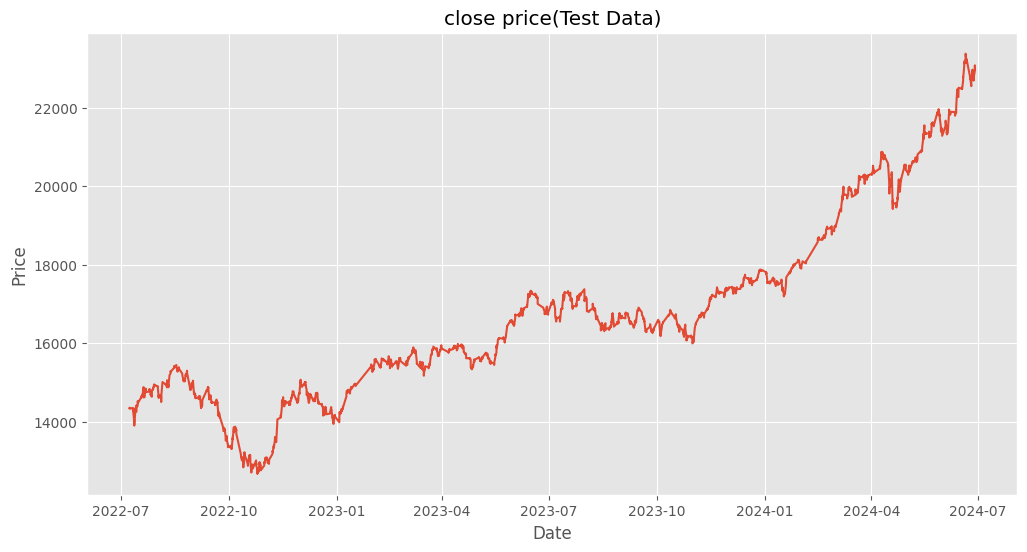

In [194]:
import matplotlib.pyplot as plt

# Assuming 'trainData' has the 'close' column, replace 'df' with 'trainData'
plt.figure(figsize=(12,6))
plt.plot(testData.index, testData['close'])  # Change here
plt.title('close price(Test Data)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()
plt.close()
#将原始的 trainData 转换为 NumPy 数组以加快计算速度


Buy Price: 15308.0, time: 2022-08-19T08:45:00.000000000
Sell Price: 15374.0, time: 2022-08-19T09:45:00.000000000
Trade completed

Buy Price: 15386.0, time: 2022-08-19T10:45:00.000000000
Sell Price: 14579.0, time: 2022-09-14T09:45:00.000000000
Trade completed

Buy Price: 13605.0, time: 2022-10-04T11:45:00.000000000
Sell Price: 14556.0, time: 2022-11-28T09:45:00.000000000
Trade completed

Buy Price: 14711.0, time: 2022-11-30T09:45:00.000000000
Sell Price: 14825.0, time: 2022-12-06T09:45:00.000000000
Trade completed

Buy Price: 15400.0, time: 2023-03-20T09:45:00.000000000
Sell Price: 15373.0, time: 2023-03-20T10:45:00.000000000
Trade completed

Buy Price: 15359.0, time: 2023-03-20T11:45:00.000000000
Sell Price: 15691.0, time: 2023-03-28T10:45:00.000000000
Trade completed

Buy Price: 15701.0, time: 2023-03-29T09:45:00.000000000
Sell Price: 16849.0, time: 2023-06-09T08:45:00.000000000
Trade completed

Buy Price: 16866.0, time: 2023-06-09T09:45:00.000000000
Sell Price: 17263.0, time: 2023-06

<Axes: xlabel='datetime'>

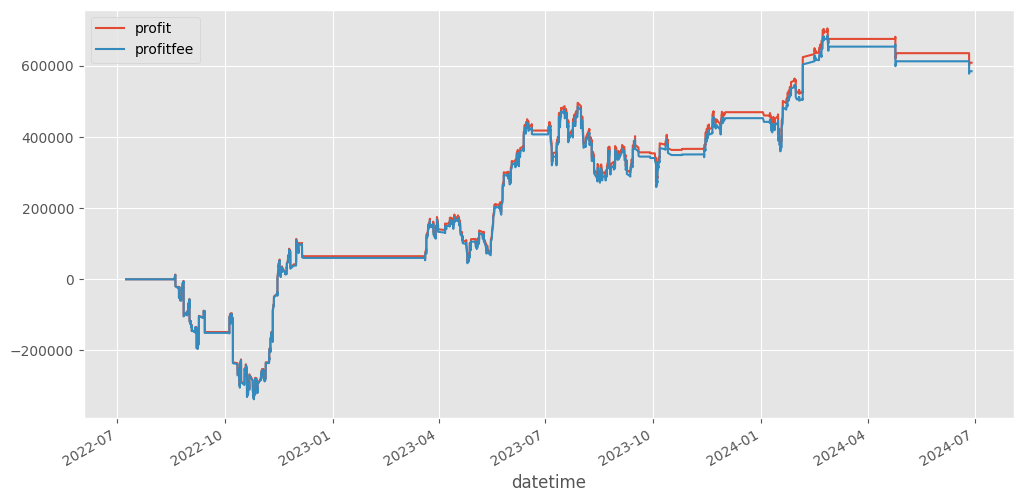

In [202]:
#建立存放資料的單位
BS = None
buy = []
sell = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []

# 定義列的索引
OPEN, HIGH, LOW, CLOSE, ADX, PLUS_DI, MINUS_DI = range(7)

#開始交易流程
for i in range(1, len(df_arr)):  # 從1開始，因為我們需要比較前一天的數據
    #回測期間最後一天就跳出這個迴圈
    if i == len(df_arr)-1:
        break

    ## 進場邏輯
    ### 當正DI由下往上穿過負DI，同时ADX高于25時進場做多
    entryLong = (df_arr[i, PLUS_DI] > df_arr[i, MINUS_DI] and
                 df_arr[i-1, PLUS_DI] <= df_arr[i-1, MINUS_DI] and
                 df_arr[i, ADX] > 25)

    ## 出場邏輯
    ### 當-DI由下往上穿過+DI，同时ADX高于25時出場
    exitLong = (df_arr[i, MINUS_DI] > df_arr[i, PLUS_DI] and
                df_arr[i-1, MINUS_DI] <= df_arr[i-1, PLUS_DI] and
                df_arr[i, ADX] > 25)

    #還沒進場不用計算損益
    if BS == None:
        profit_list.append(0)
        profit_fee_list.append(0)

    #確認進場&相關設定
    if BS == None and entryLong:
        #更改狀態至做多
        BS = 'B'
        #紀錄進場時間
        t = i+1
        buy.append(t)
        print(f"Buy Price: {df_arr[t,CLOSE]}, time: {time_arr[t]}")

    #進場開始計算未實現損益
    elif BS == 'B':
        profit = 200 * (df_arr[i+1,CLOSE] - df_arr[i,CLOSE])
        profit_list.append(profit)

        #近場條件達成，計算未實現損益-交易成本
        if exitLong or i == len(df_arr)-2:
            pl_round = 200 * (df_arr[i+1,CLOSE] - df_arr[t,CLOSE])
            profit_fee = profit - feePaid*2
            profit_fee_list.append(profit_fee)
            #紀錄出場時間
            sell.append(i+1)
            #重置交易狀態
            BS = None
            print(f"Sell Price: {df_arr[i+1,CLOSE]}, time: {time_arr[i+1]}")
            print("Trade completed")
            print()
            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2
            profit_fee_list_realized.append(profit_fee_realized)
        #出場條件未達成，計算未實現損益
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)

equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=testData.index[:len(profit_list)])
equity.plot(grid=True, figsize=(12,6))



In [197]:
print(equity)

                       profit  profitfee
datetime                                
2022-07-08 10:45:00       0.0        0.0
2022-07-08 11:45:00       0.0        0.0
2022-07-08 12:45:00       0.0        0.0
2022-07-11 08:45:00       0.0        0.0
2022-07-11 09:45:00       0.0        0.0
...                       ...        ...
2024-06-27 12:45:00  608400.0   584400.0
2024-06-28 08:45:00  608400.0   584400.0
2024-06-28 09:45:00  608400.0   584400.0
2024-06-28 10:45:00  608400.0   584400.0
2024-06-28 11:45:00  608400.0   584400.0

[2398 rows x 2 columns]


In [204]:
equity['equity'] = equity['profitfee'] + fund
equity['drawdown_percent'] = (equity['equity']/equity['equity'].cummax()) - 1
equity['drawdown'] = equity['equity'] - equity['equity'].cummax() #前n個元素的最大值
#print(profit_fee_list_realized)
profit = equity['profitfee'].iloc[-1]
ret = equity['equity'][-1]/equity['equity'][0] - 1
mdd = abs(equity['drawdown_percent'].min())
calmarRatio = ret / mdd
tradeTimes = len(buy)
winRate = len([i for i in profit_fee_list_realized if i > 0]) / len(profit_fee_list_realized)
profitFactor = sum([i for i in profit_fee_list_realized if i>0]) / abs(sum([i for i in profit_fee_list_realized if i<0]))

print('Profit : ',profit)
print('Return : ',ret)
print('Max DrawDown : ',mdd)
print('Caimar Ratio : ',calmarRatio)
print('Trade Times : ',tradeTimes)
print('Win Rate : ',winRate)
print('Profit Factor : ',profitFactor)


Profit :  584400.0
Return :  0.5844
Max DrawDown :  0.3450592885375494
Caimar Ratio :  1.693621993127148
Trade Times :  20
Win Rate :  0.6
Profit Factor :  2.752849430113977


<ipython-input-204-d31c005205ce>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret = equity['equity'][-1]/equity['equity'][0] - 1


Index([2022, 2023, 2024], dtype='int32', name='datetime')


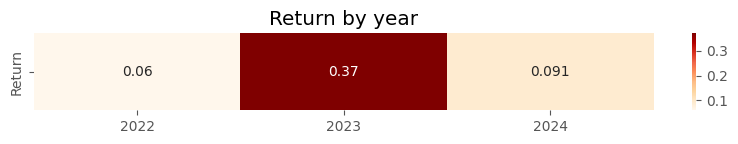


           Jan      Feb       Mar       Apr       May       Jun       Jul  \
2022  0.000000 -0.11920 -0.035868 -0.135154  0.489265 -0.030901  0.000000   
2023  0.018053 -0.06337 -0.006816  0.007459  0.071080  0.000000  0.036349   
2024       NaN      NaN       NaN       NaN       NaN       NaN       NaN   

           Aug       Sep       Oct       Nov       Dec  
2022  0.000000  0.069057 -0.022808  0.145027  0.105958  
2023  0.098446  0.000000 -0.024915  0.000000 -0.017365  
2024       NaN       NaN       NaN       NaN       NaN  


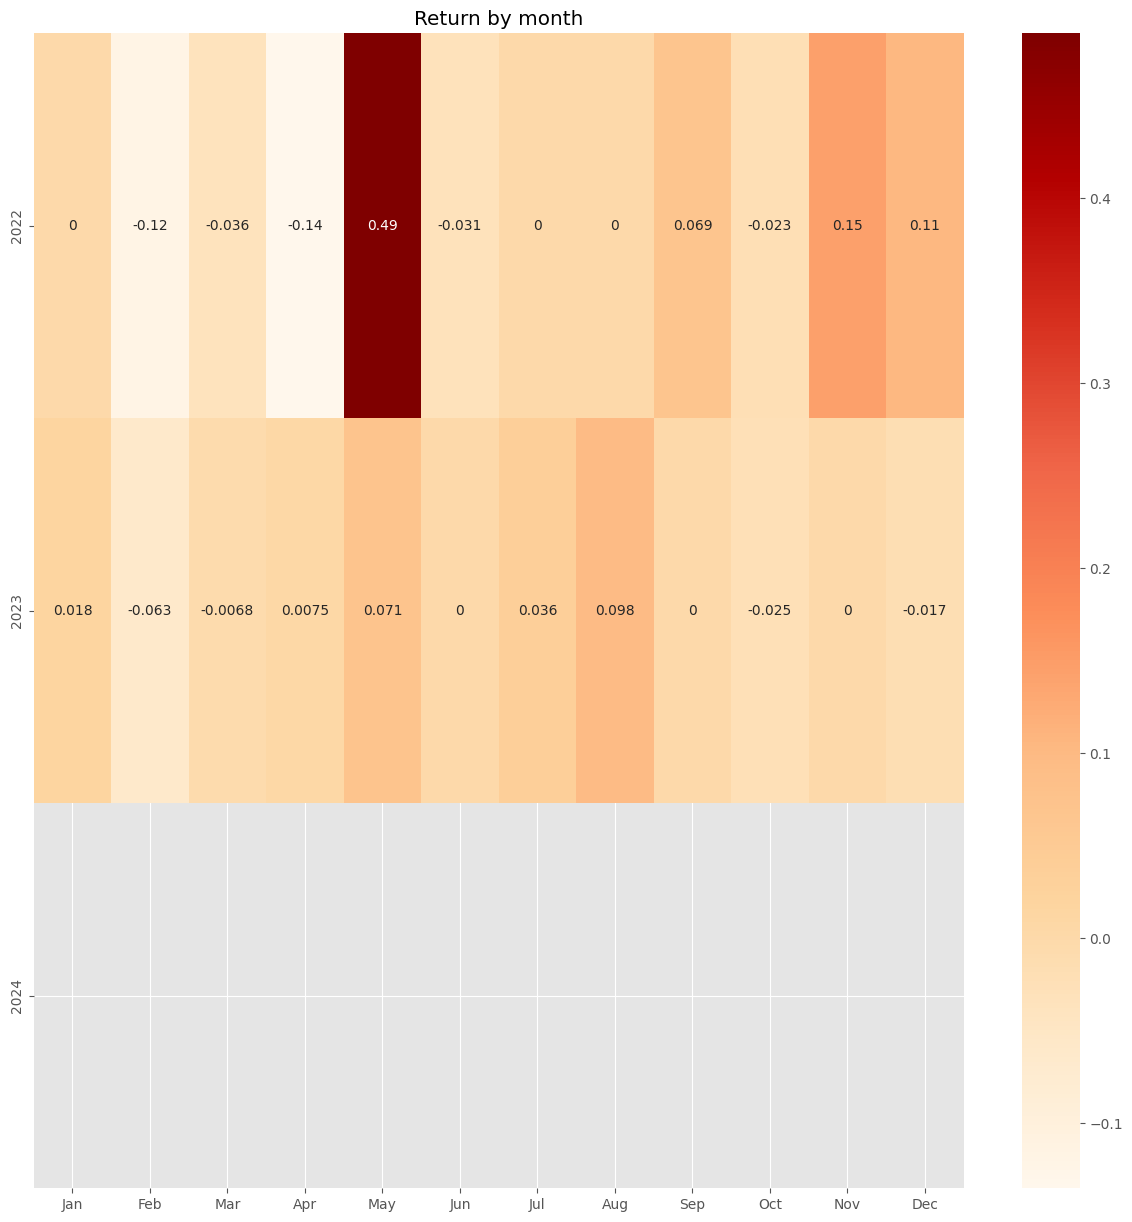

In [208]:
import matplotlib.pyplot as plt
import seaborn as sns

#時間損益(年)
equity.index = pd.to_datetime(equity.index) #確保索引是datetime型態
years = ['2022', '2023', '2024']
year_ret = []
print(equity.index.year.unique())
for i in equity.index.year.unique():
    year_ret.append(equity[equity.index.year == i]['equity'].iloc[-1]/equity[equity.index.year == i]['equity'].iloc[0] - 1)

df = pd.DataFrame({'Return':year_ret},index = years)

# heatmap函式
plt.figure(figsize=(10,1))  # Change 'py' to 'plt'
sns.heatmap(df.transpose(), annot=True, cmap='OrRd')
plt.title('Return by year')  # Change 'py' to 'plt'
plt.show()
print('')

# 時間損益(月)
group_data = equity.groupby([equity.index.year, equity.index.month])

month_ret = []
for group, data in group_data:
    month_ret.append(data['equity'].iloc[-1]/data['equity'].iloc[0] - 1)

# Determine the number of years present in the data
num_years = len(equity.index.year.unique())

month_ret_padded = np.append(month_ret, [np.nan] * (num_years*12 - len(month_ret))) # Adjust padding
df = pd.DataFrame(np.array(month_ret_padded).reshape((num_years,12)), # Reshape using num_years
                    columns=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
                    index = years)

print(df)
plt.figure(figsize=(15,15))  # Change 'py' to 'plt'
sns.heatmap(df, annot=True, cmap='OrRd')
plt.title('Return by month')  # Change 'py' to 'plt'
plt.show()

datetime
2022-08-19 08:45:00         inf
2022-08-19 09:45:00    0.000000
2022-08-19 10:45:00   -0.242424
2022-08-19 11:45:00   -0.340000
2022-08-19 12:45:00   -3.878788
                         ...   
2024-06-27 12:45:00    0.000000
2024-06-28 08:45:00    0.000000
2024-06-28 09:45:00    0.000000
2024-06-28 10:45:00    0.000000
2024-06-28 11:45:00    0.000000
Name: profit, Length: 2250, dtype: float64


NameError: name 'py' is not defined

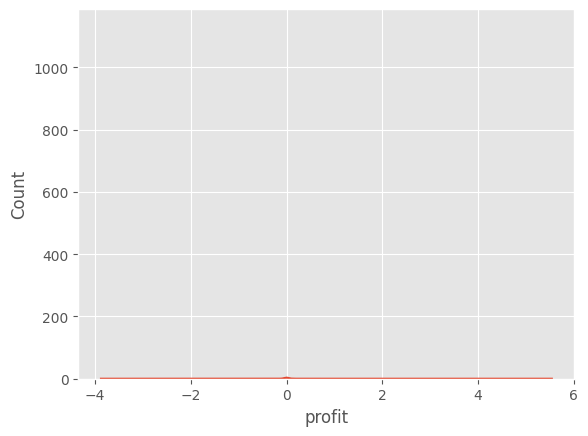

In [209]:
# 損益分布
rets = equity['profit'].pct_change().dropna() # Calculate returns based on 'profit' column
print(rets)
sns.histplot(rets, kde=True)
py.xlabel('Return per trade')
py.ylabel('Frequency')
py.title('Profit Loss Distribution')
py.show()

In [ ]:
# quantstats回測報表
!pip install quantstats
import quantstats
ret = equity['equity'].pct_change(periods=1).dropna()
print(ret)
quantstats.reports.full(ret)
#quantstats.reports.html(ret,output='stats.html',title='backtest result',download_filename='result.html')

### 優化參數

In [ ]:
# 1. 數據切分
def split_data(df):
    training_end = datetime(2019, 12, 31)
    validation_end = datetime(2022, 12, 31)

    training_set = df[df.index <= training_end]
    validation_set = df[(df.index > training_end) & (df.index <= validation_end)]
    testing_set = df[df.index > validation_end]

    return training_set, validation_set, testing_set

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from talib import ADX, PLUS_DI, MINUS_DI
from sklearn.model_selection import train_test_split

def calculate_indicators(df, adx_period):
    high = df['High'].values
    low = df['Low'].values
    close = df['Close'].values

    df['ADX'] = ADX(high, low, close, timeperiod=adx_period)
    df['+DI'] = PLUS_DI(high, low, close, timeperiod=adx_period)
    df['-DI'] = MINUS_DI(high, low, close, timeperiod=adx_period)

    return df

def backtest_strategy(df, adx_threshold, fee):
    BS = None
    buy = []
    sell = []
    profit_list = [0]
    profit_fee_list = [0]
    profit_fee_list_realized = []

    df_arr = df[['Open', 'High', 'Low', 'Close', 'ADX', '+DI', '-DI']].values
    time_arr = df.index

    for i in range(1, len(df_arr) - 1):
        entryLong = (df_arr[i, 5] > df_arr[i, 6] and
                     df_arr[i-1, 5] <= df_arr[i-1, 6] and
                     df_arr[i, 4] > adx_threshold)

        exitLong = (df_arr[i, 6] > df_arr[i, 5] and
                    df_arr[i-1, 6] <= df_arr[i-1, 5] and
                    df_arr[i, 4] > adx_threshold)

        if BS is None:
            profit_list.append(0)
            profit_fee_list.append(0)

            if entryLong:
                BS = 'B'
                t = i + 1
                buy.append(t)
                print(f"Buy Price: {df_arr[t, 3]}, time: {time_arr[t]}")

        elif BS == 'B':
            profit = 200 * (df_arr[i+1, 3] - df_arr[i, 3])
            profit_list.append(profit)

            if exitLong or i == len(df_arr) - 2:
                pl_round = 200 * (df_arr[i+1, 3] - df_arr[t, 3])
                profit_fee = profit - fee * 2
                profit_fee_list.append(profit_fee)
                sell.append(i + 1)
                BS = None
                print(f"Sell Price: {df_arr[i+1, 3]}, time: {time_arr[i+1]}")
                print("Trade completed")
                print()
                profit_fee_realized = pl_round - fee * 2
                profit_fee_list_realized.append(profit_fee_realized)
            else:
                profit_fee = profit
                profit_fee_list.append(profit_fee)

    equity = pd.DataFrame({
        'profit': np.cumsum(profit_list),
        'profitfee': np.cumsum(profit_fee_list)
    }, index=df.index[:len(profit_list)])

    return equity, profit_fee_list_realized

def optimize_parameters(train_df, adx_periods, adx_thresholds, fee):
    results = []
    for adx_period in adx_periods:
        df = calculate_indicators(train_df.copy(), adx_period)
        for adx_threshold in adx_thresholds:
            equity, realized_profits = backtest_strategy(df, adx_threshold, fee)
            total_return = equity['profitfee'].iloc[-1]
            sharpe_ratio = np.sqrt(252) * equity['profitfee'].pct_change().mean() / equity['profitfee'].pct_change().std()
            results.append((adx_period, adx_threshold, total_return, sharpe_ratio))

    results_df = pd.DataFrame(results, columns=['ADX_Period', 'ADX_Threshold', 'Total_Return', 'Sharpe_Ratio'])
    return results_df.sort_values('Sharpe_Ratio', ascending=False).iloc[0]

# 主程序
if __name__ == "__main__":
    # 加载数据
    df = pd.read_csv('your_data.csv')  # 请替换为您的数据文件路径
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    # 分割数据集
    train_df, temp_df = train_test_split(df, test_size=0.3, shuffle=False)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, shuffle=False)

    # 定义参数范围
    adx_periods = range(10, 51, 5)
    adx_thresholds = range(20, 31, 1)
    fee = 0.01  # 假设交易费用为0.01，您可以根据实际情况调整

    # 在训练集上优化参数
    best_params = optimize_parameters(train_df, adx_periods, adx_thresholds, fee)
    print("Best parameters:", best_params)

    # 使用最佳参数在验证集上测试
    val_df = calculate_indicators(val_df, best_params['ADX_Period'])
    val_equity, val_realized_profits = backtest_strategy(val_df, best_params['ADX_Threshold'], fee)
    print(f"Validation set - Total Return: {val_equity['profitfee'].iloc[-1]:.2f}, Sharpe Ratio: {np.sqrt(252) * val_equity['profitfee'].pct_change().mean() / val_equity['profitfee'].pct_change().std():.2f}")

    # 在测试集上进行最终测试
    test_df = calculate_indicators(test_df, best_params['ADX_Period'])
    test_equity, test_realized_profits = backtest_strategy(test_df, best_params['ADX_Threshold'], fee)
    print(f"Test set - Total Return: {test_equity['profitfee'].iloc[-1]:.2f}, Sharpe Ratio: {np.sqrt(252) * test_equity['profitfee'].pct_change().mean() / test_equity['profitfee'].pct_change().std():.2f}")

    # 绘制测试集的权益曲线
    plt.figure(figsize=(12, 6))
    test_equity['profitfee'].plot(grid=True)
    plt.title('Equity Curve on Test Set')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.show()

In [210]:
def backtest_strategy(df, adx_threshold, fee):
    BS = None
    buy = []
    sell = []
    profit_list = [0]
    profit_fee_list = [0]
    profit_fee_list_realized = []

    df_arr = df[['Open', 'High', 'Low', 'Close', 'ADX', '+DI', '-DI']].values
    time_arr = df.index